In [51]:
import sys
!{sys.executable} -m pip install statsbombpy
from statsbombpy import sb


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
comps = sb.competitions()
comps[comps["competition_name"]=="Premier League"]
comps.sort_values(by="season_name",ascending=False).head(10)
comp_match_counts = {}
for _, row in comps.sort_values(by="season_name",ascending=False).head(20).iterrows():
    matches = sb.matches(row["competition_id"], row["season_id"])
    comp_match_counts[f"{row['competition_name']} ({row['season_name']})"] = len(matches)
comp_match_counts


{'Copa America (2024)': 32,
 'UEFA Euro (2024)': 51,
 '1. Bundesliga (2023/2024)': 34,
 'African Cup of Nations (2023)': 52,
 "Women's World Cup (2023)": 64,
 'Major League Soccer (2023)': 6,
 'Ligue 1 (2022/2023)': 32,
 "UEFA Women's Euro (2022)": 31,
 'FIFA World Cup (2022)': 64,
 'Ligue 1 (2021/2022)': 26,
 'Indian Super league (2021/2022)': 115,
 "FA Women's Super League (2020/2021)": 131,
 'La Liga (2020/2021)': 35,
 'UEFA Euro (2020)': 51,
 'La Liga (2019/2020)': 33,
 "FA Women's Super League (2019/2020)": 87,
 "Women's World Cup (2019)": 52,
 'Champions League (2018/2019)': 1,
 'La Liga (2018/2019)': 34,
 "FA Women's Super League (2018/2019)": 108}

In [53]:
comps[comps["competition_name"]=="Premier League"]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
64,2,27,England,Premier League,male,False,False,2015/2016,2024-06-12T07:43:56.243851,2021-06-13T16:17:31.694,None,2024-06-12T07:43:56.243851
65,2,44,England,Premier League,male,False,False,2003/2004,2024-03-08T14:49:13.195793,2021-06-13T16:17:31.694,None,2024-03-08T14:49:13.195793


In [54]:
print("Amount of Games: ",sb.matches(2,27).shape[0])
sb.matches(2,27).head()

Amount of Games:  380


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3754058,2016-01-02,16:00:00.000,England - Premier League,2015/2016,Leicester City,AFC Bournemouth,0,0,available,...,2021-06-12T16:17:31.694,20,Regular Season,King Power Stadium,Andre Marriner,Claudio Ranieri,Eddie Howe,1.1.0,2,2
1,3754245,2015-10-17,16:00:00.000,England - Premier League,2015/2016,West Bromwich Albion,Sunderland,1,0,available,...,2021-06-13T16:17:31.694,9,Regular Season,The Hawthorns,Martin Atkinson,Tony Pulis,Sam Allardyce,1.1.0,2,2
2,3754136,2015-12-19,18:30:00.000,England - Premier League,2015/2016,Newcastle United,Aston Villa,1,1,available,...,2021-06-13T16:17:31.694,17,Regular Season,St. James'' Park,Martin Atkinson,Steve McClaren,Rémi Garde,1.1.0,2,2
3,3754037,2016-04-30,16:00:00.000,England - Premier League,2015/2016,Everton,AFC Bournemouth,2,1,available,...,2021-06-12T16:17:31.694,36,Regular Season,Goodison Park,Neil Swarbrick,Roberto Martínez Montoliú,Eddie Howe,1.1.0,2,2
4,3754039,2016-02-13,16:00:00.000,England - Premier League,2015/2016,Crystal Palace,Watford,1,2,available,...,2021-06-12T16:17:31.694,26,Regular Season,Selhurst Park,Robert Madley,Alan Pardew,Enrique Sánchez Flores,1.1.0,2,2


In [86]:
ordered_events =  sb.events(3754058).sort_values(by=["period","timestamp"],ascending=[True,True])

In [87]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np
import pandas as pd

In [88]:
ordered_events = ordered_events[~ordered_events["location"].isna()]

In [89]:
outcome_cols = ['ball_recovery_recovery_failure','dribble_outcome','duel_outcome',"interception_outcome","pass_outcome","shot_outcome"]
end_coord_cols = ['pass_end_location','carry_end_location','shot_end_location']
events = {
    "Pass": {"outcome": 'pass_outcome', 'end_loc': 'pass_end_location'},
    "Carry": {'end_loc': 'carry_end_location'},
    "Ball Recovery": {"outcome": 'ball_recovery_recovery_failure'},
    "Duel": {"outcome": 'duel_outcome'},
    "Clearance": {},
    "Miscontrol": {},
    "Dribble": {"outcome": 'dribble_outcome'},
    "Shot": {"outcome": 'shot_outcome', 'end_loc': 'shot_end_location'},
    "Interception": {"outcome": 'interception_outcome'},
    "Foul Committed": {}
}
cols = [col for col in ordered_events.columns if any([event.lower().replace(" ","_") in col.lower() for event in events.keys()])] + ["type","possession","possession_team","team",'team_id',"location","timestamp","period","duration","id","match_id","minute","second",'player','player_id','under_pressure','period','position']
cols =sorted(cols)
ordered_events = ordered_events[ordered_events["type"].isin(events.keys())][cols]

#make one outcome column
def get_outcome(row):
    event_type = row["type"]
    event_dict = events.get(event_type)

    if event_type == "Ball Recovery":
        recovery_failure = row.get("ball_recovery_recovery_failure", None)
        return True if pd.isna(recovery_failure) else not recovery_failure

    if "outcome" in event_dict:
        outcome_col = event_dict["outcome"]
        return row.get(outcome_col, None)

    return np.nan

ordered_events["outcome"] = ordered_events.apply(get_outcome, axis=1)
ordered_events['outcome'].unique()
ordered_events['outcome'] = ordered_events['outcome'].apply(lambda x: False if x in {'Out', 'Incomplete', 'Blocked','Lost Out', 'Complete', False, 'Unknown', 'Off T',
       'Lost In Play', 'Wayward', 'Post', 'Saved', 'Injury Clearance',
       'Pass Offside'} else True)
""" NEED TO FIX THIS BC NAN DUELS ARE FAILED DUELS BUT NAN PASSES ARE SUCCESSFUL PASSES"""


#make one end_loc column
def get_end_loc(row):
    event_type = row["type"]
    event_dict = events.get(event_type)
    if "end_loc" in event_dict:
        return row.get(event_dict["end_loc"], None)
    return np.nan

ordered_events["end_loc"] = ordered_events.apply(get_end_loc, axis=1)


In [95]:
ordered_events[ordered_events["type"]=="Duel"][["outcome","duel_outcome","possession","team","possession_team","timestamp"]].sort_values(by=["possession","timestamp"]).head(50)

,outcome,duel_outcome,possession,team,possession_team,timestamp
3066,True,Success In Play,3,AFC Bournemouth,Leicester City,00:00:59.043
3067,True,NaN,3,AFC Bournemouth,Leicester City,00:01:02.145
3068,True,NaN,3,Leicester City,Leicester City,00:01:05.446
3069,True,Won,4,AFC Bournemouth,AFC Bournemouth,00:01:39.421
3070,False,Lost Out,4,Leicester City,AFC Bournemouth,00:01:54.309
3071,False,Lost Out,6,Leicester City,AFC Bournemouth,00:02:51.112
3072,True,Success In Play,13,Leicester City,AFC Bournemouth,00:06:32.074
3073,True,NaN,18,AFC Bournemouth,Leicester City,00:11:00.161
3074,True,NaN,22,Leicester City,Leicester City,00:14:15.409
3075,True,Success In Play,23,AFC Bournemouth,AFC Bournemouth,00:14:28.712


In [72]:
#change type of event for special pass types
special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]

In [73]:
# Split events by team
away_team = ordered_events[ordered_events["team"] == "Leicester City"].copy()
home_team = ordered_events[ordered_events["team"] == "AFC Bournemouth"].copy()

# Function to flip coordinates
def flip_coordinates(coords):
    if isinstance(coords, list):
        return [120 - coords[0], 80 - coords[1]]
    return coords

# Flip all coordinate columns for away team
coordinate_columns = ["location", "end_loc"]
for column in coordinate_columns:
    away_team[column] = away_team[column].apply(flip_coordinates)

# Combine home and away events
ordered_events = pd.concat([home_team, away_team])


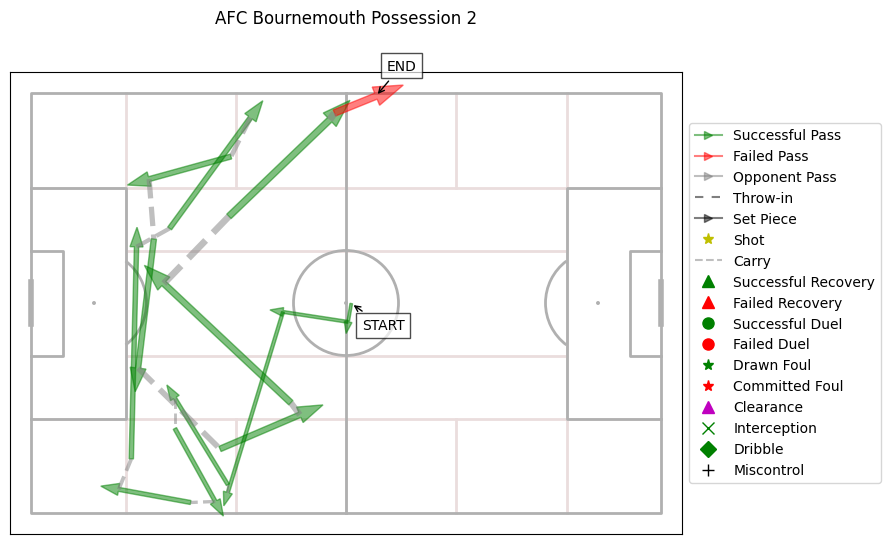

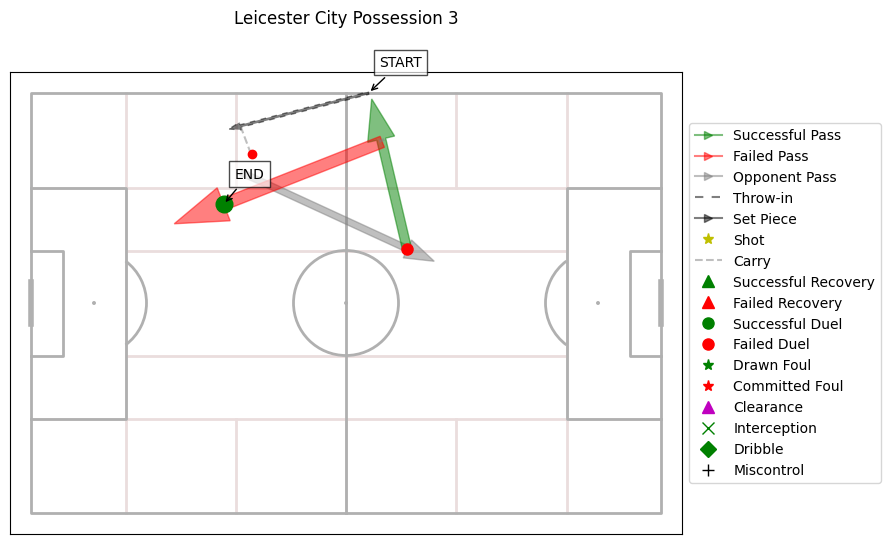

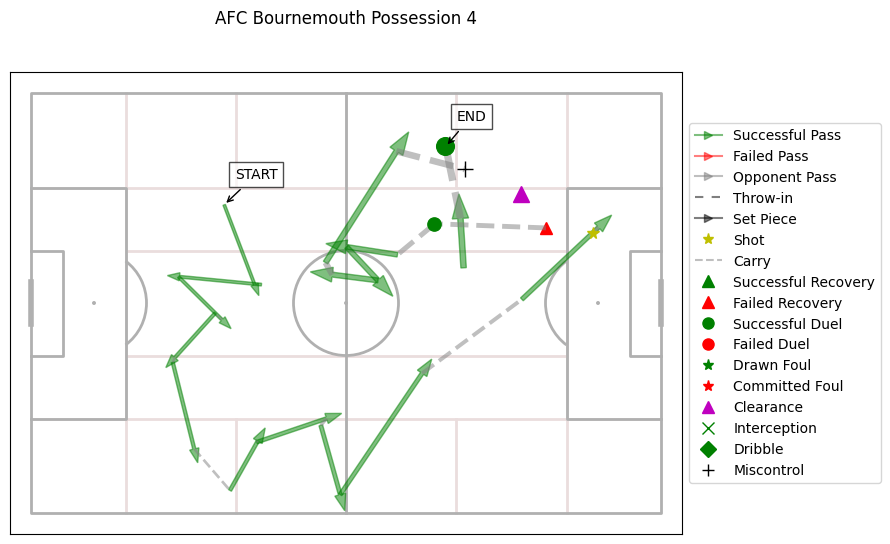

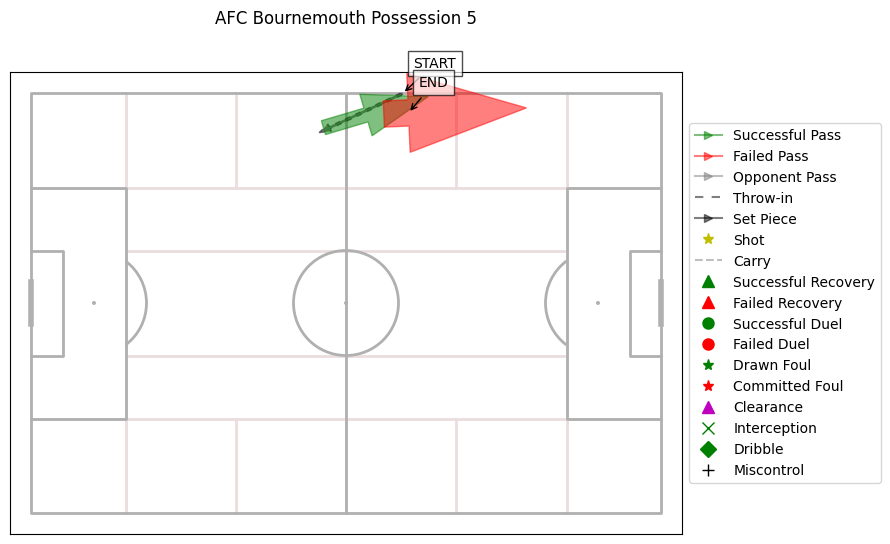

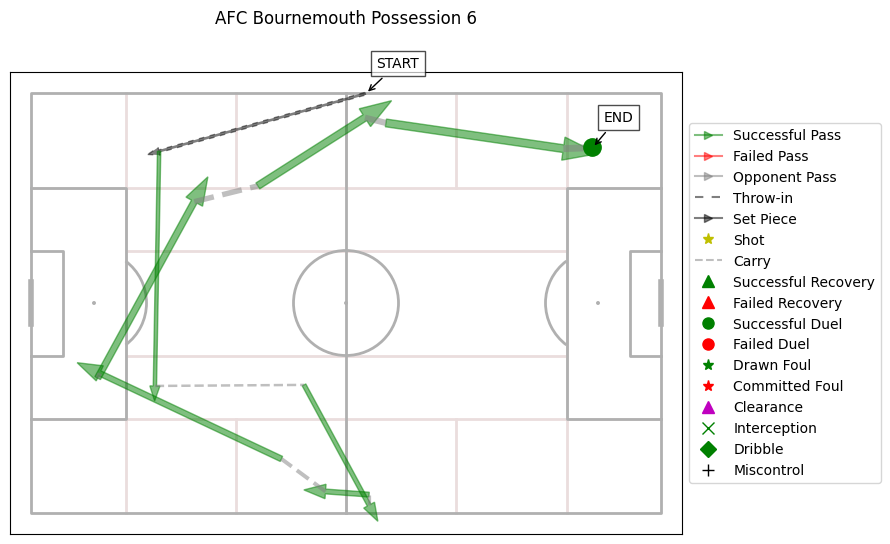

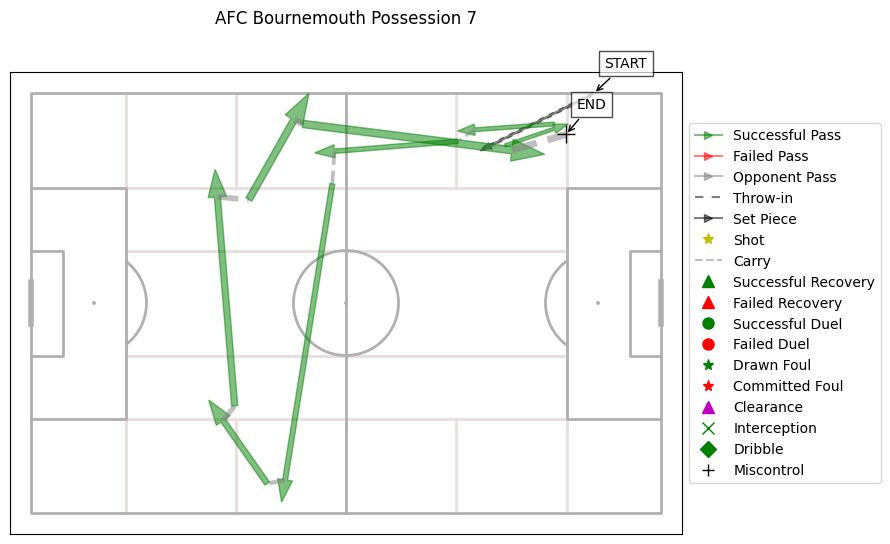

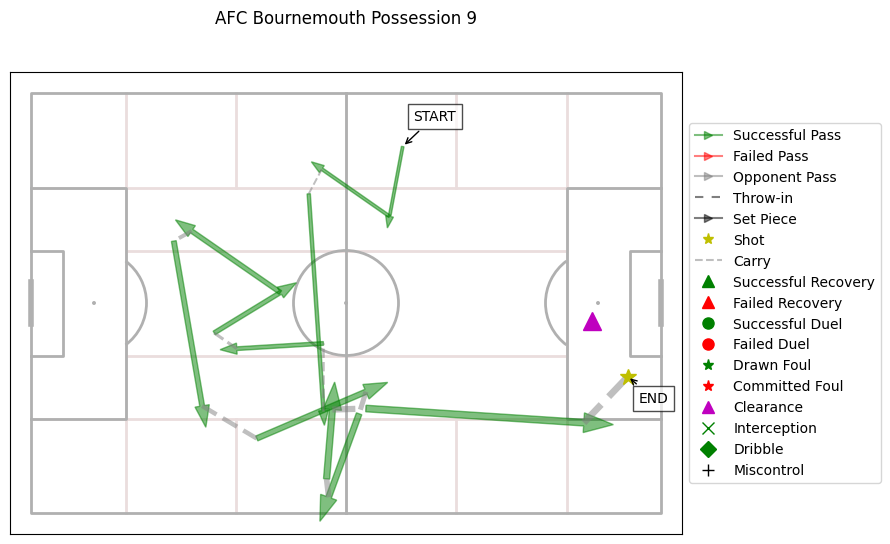

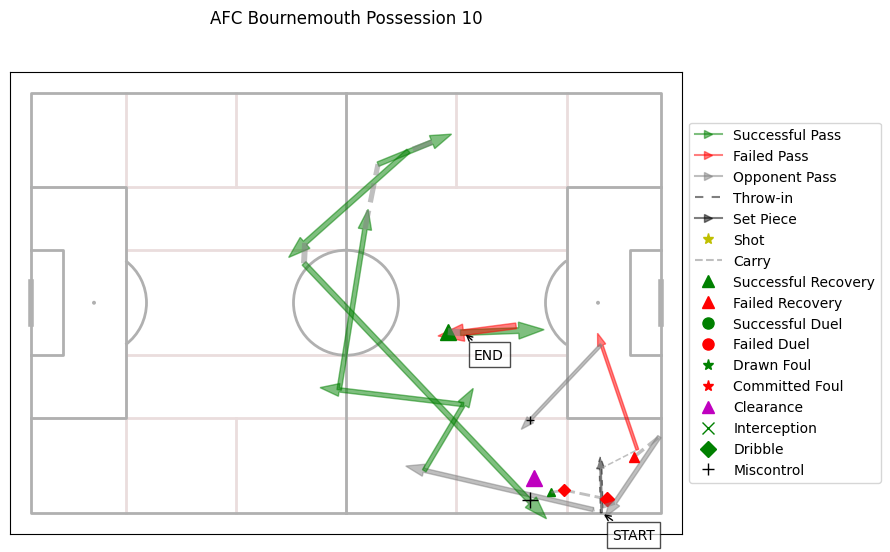

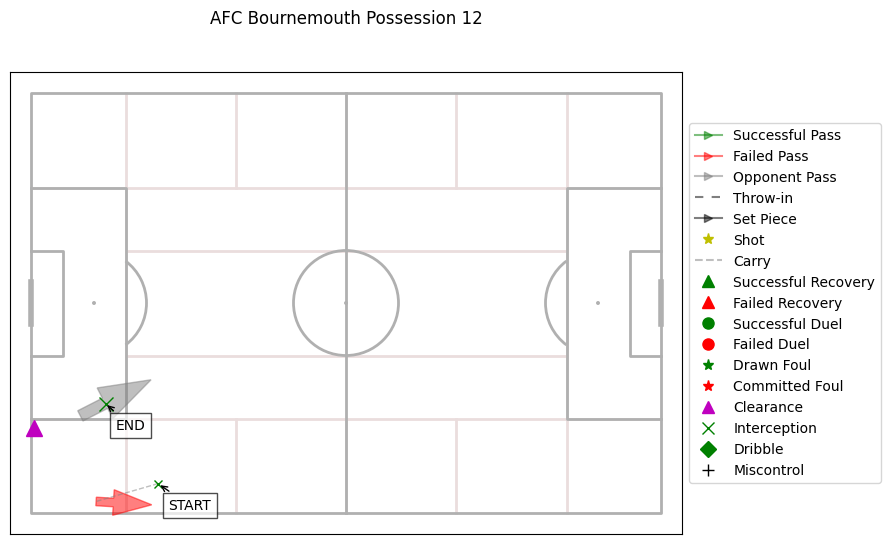

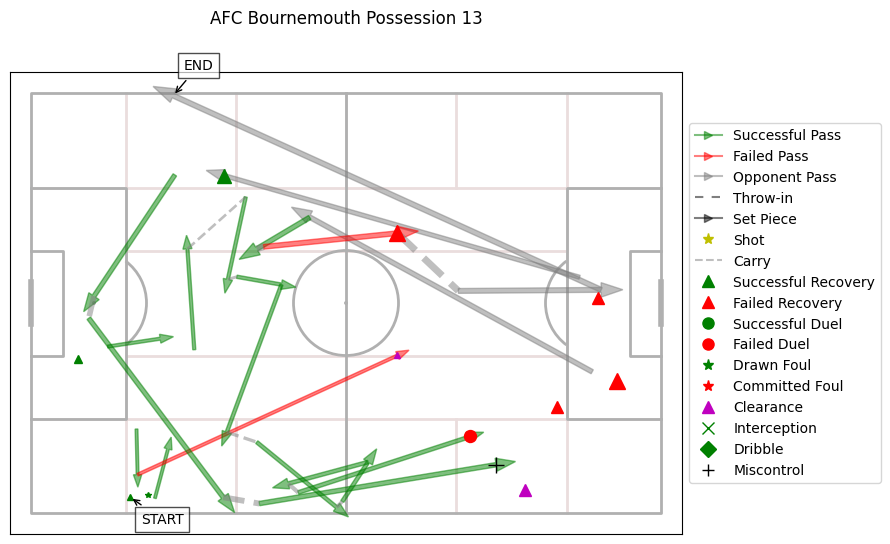

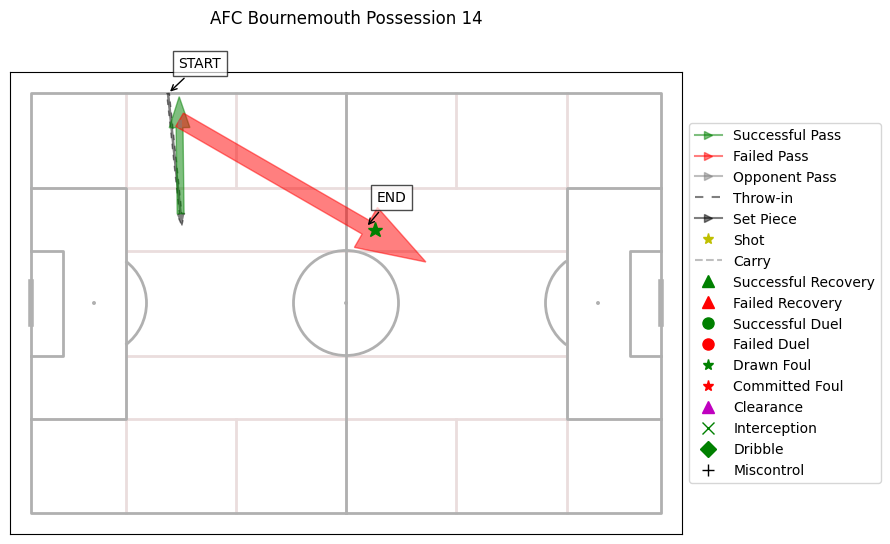

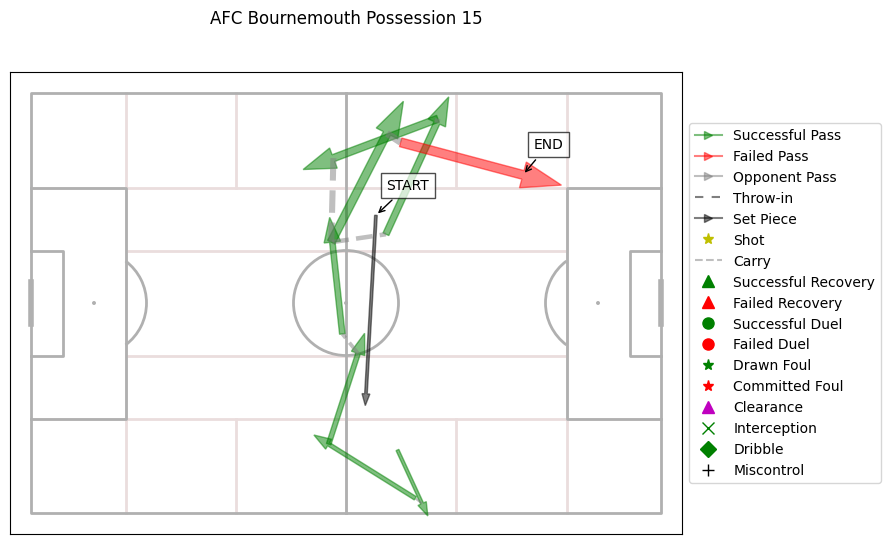

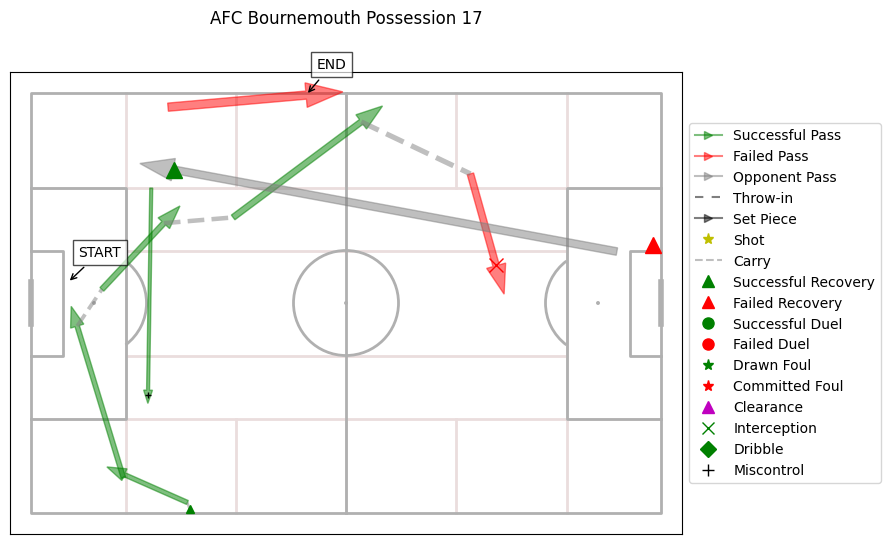

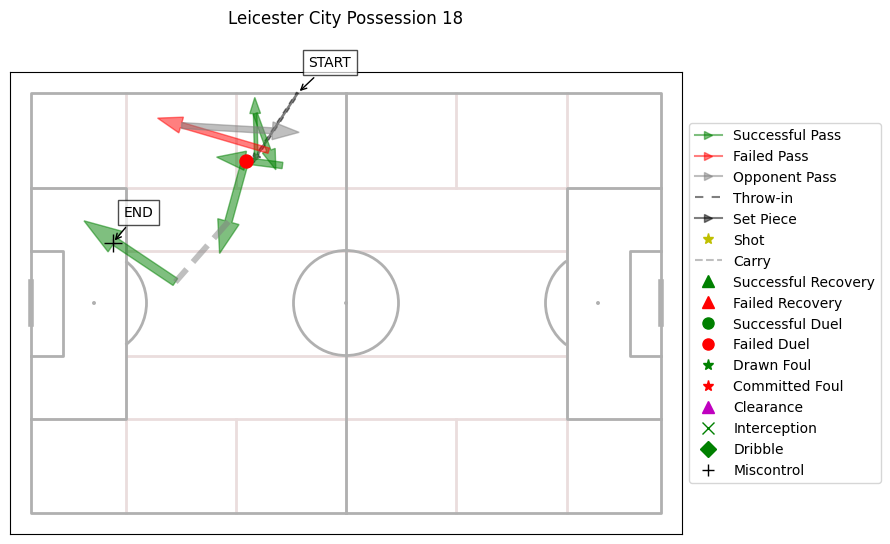

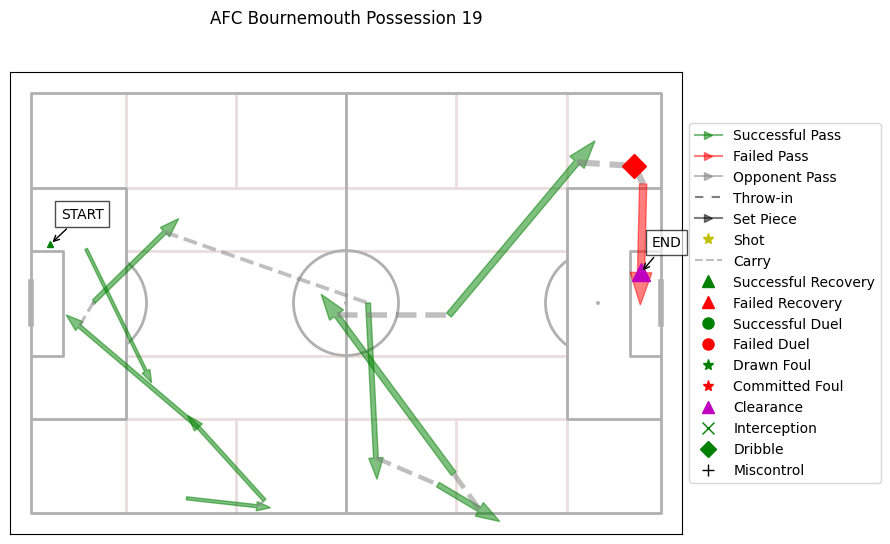

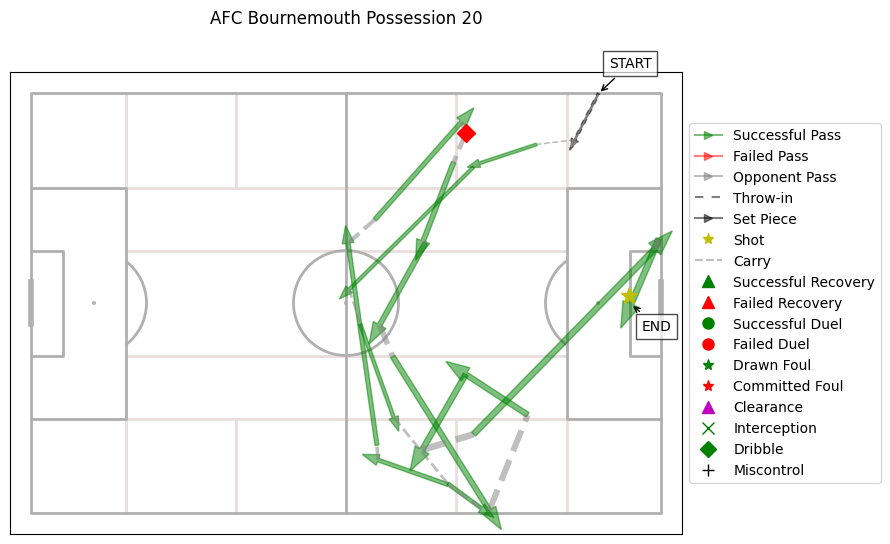

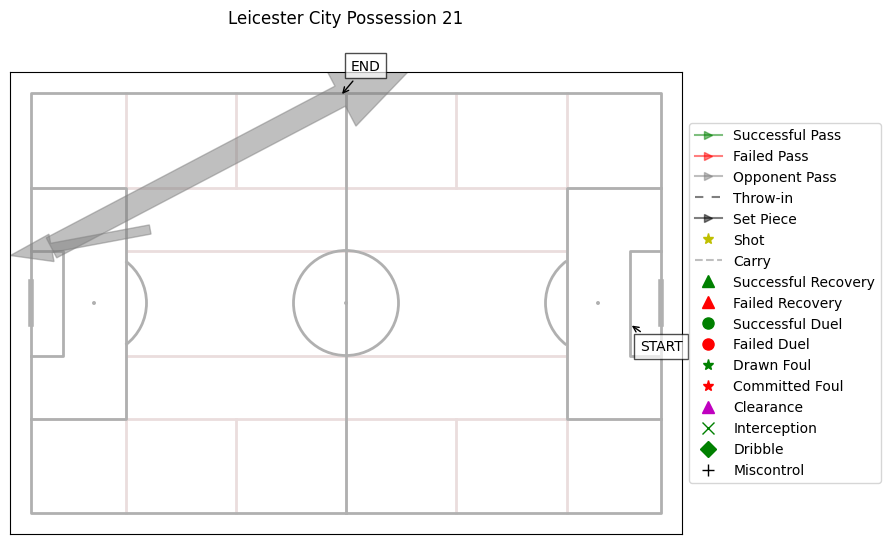

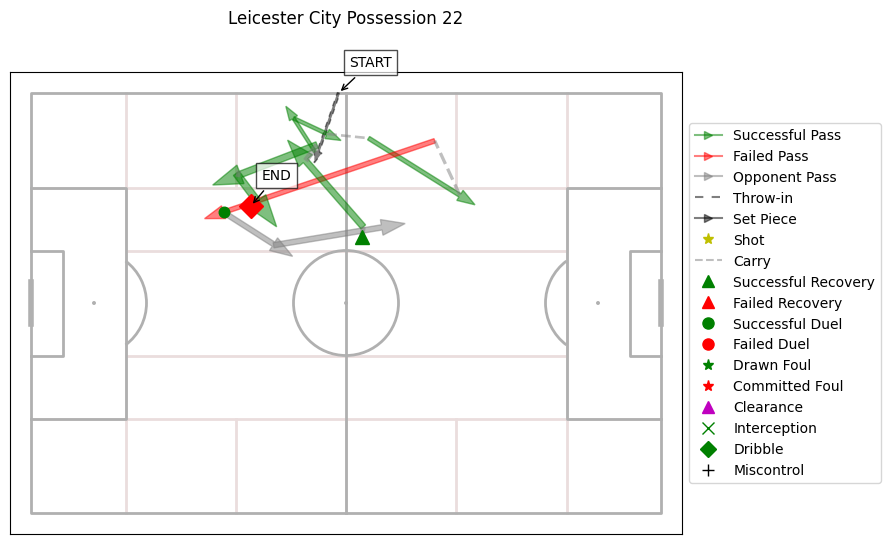

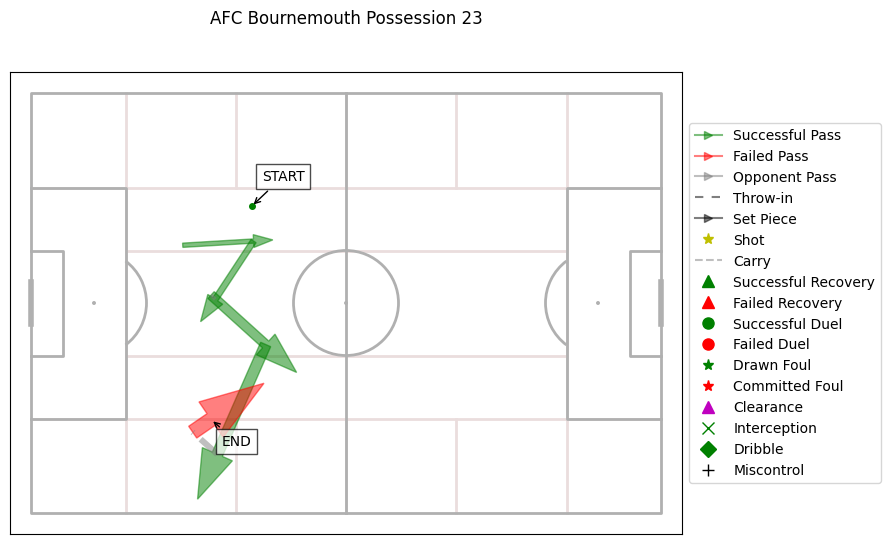

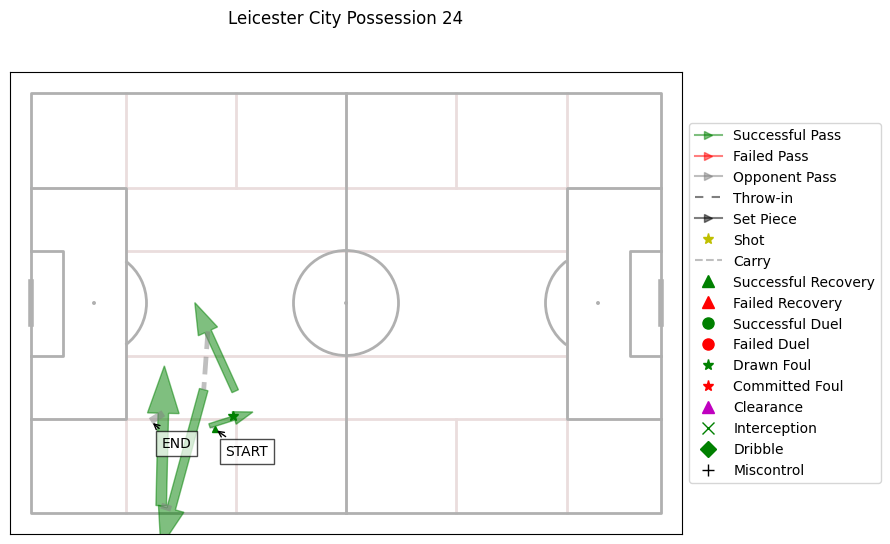

In [76]:
def plot_possession(possession):
    possession_events = ordered_events[ordered_events["possession"] == possession]
    team = possession_events["possession_team"].unique()[0]
    
    # Create pitch visualization
    pitch = Pitch(positional=True, axis=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    pitch.draw(ax=ax)
    
    # Sort events by timestamp and calculate width increment
    possession_events = possession_events.sort_values(by=["timestamp"], ascending=True)
    min_width = .5
    max_width = 5
    width_increment = (max_width - min_width) / len(possession_events)
    
    # Get first and last event locations
    first_event = possession_events.iloc[0]
    last_event = possession_events.iloc[-1]
    start_x, start_y = first_event["location"]
    end_x, end_y = last_event["location"]
    
    # Plot each event
    j=0
    for i, event in possession_events.iterrows():
        x, y = event["location"]
        event_team = event["team"]
        width = min_width + j * width_increment
        marker_size = 4 + j * 2

        if event["type"] in ["Corner", "Free Kick", "Throw-in"] and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            color = 'k'
            linestyle = (0, (4, 4, 4, 4)) if event["type"] == "Throw-in" else '-'
            if event_team != team:
                color = 'gray'
            plt.arrow(x, y, end_x-x, end_y-y, color=color, alpha=0.5, width=width, ls=linestyle)
            
        elif event["type"] == "Pass" and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            color = 'g' if event["outcome"] else 'r'
            if event_team != team:
                color = 'gray'
            plt.arrow(x, y, end_x-x, end_y-y, color=color, alpha=0.5, width=width, ls='-')
            
        elif event["type"] == "Shot":
            plt.plot(x, y, 'y*', markersize=marker_size)
            
        elif event["type"] == "Ball Recovery":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}^', markersize=marker_size)
            
        elif event["type"] == "Carry" and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            plt.plot([x, end_x], [y, end_y], color='gray', alpha=0.5, linewidth=1+j, linestyle='--')
            
        elif event["type"] == "Duel":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'  # Opponent won duel = red
            else:
                color = 'r' if not event["outcome"] else 'g'  # Team won duel = green
            plt.plot(x, y, f'{color}o', markersize=marker_size)
            
        elif event["type"] == "Foul Committed":
            if event_team != team:
                color = 'g' if event["outcome"] else 'r'
            else:
                color = 'r' if event["outcome"] else 'g'
            plt.plot(x, y, f'{color}*', markersize=marker_size)
            
        elif event["type"] == "Clearance":
            plt.plot(x, y, 'm^', markersize=marker_size)

        elif event["type"] == "Interception":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}x', markersize=marker_size)
            
        elif event["type"] == "Dribble":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}D', markersize=marker_size)
            
        elif event["type"] == "Miscontrol":
            plt.plot(x, y, 'k+', markersize=marker_size)
            
        j+=width_increment
    
    # Add start and end text annotations
    offset = 5
    start_offset = offset if start_y > 40 else -offset
    end_offset = offset if end_y > 40 else -offset
    plt.annotate('START', xy=(start_x, start_y), xytext=(start_x+2, start_y+start_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    plt.annotate('END', xy=(end_x, end_y), xytext=(end_x+2, end_y+end_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    
    # Add title after annotations to ensure it's on top
    plt.title(f"{team} Possession {possession}", pad=35)  # Added padding to avoid overlap
            
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='g', marker='>', linestyle='-', label='Successful Pass', alpha=0.5),
        plt.Line2D([0], [0], color='r', marker='>', linestyle='-', label='Failed Pass', alpha=0.5),
        plt.Line2D([0], [0], color='gray', marker='>', linestyle='-', label='Opponent Pass', alpha=0.5),
        plt.Line2D([0], [0], color='k', linestyle=(0, (4, 4, 4, 4)), label='Throw-in', alpha=0.5),
        plt.Line2D([0], [0], color='k', marker='>', linestyle='-', label='Set Piece', alpha=0.5),
        plt.Line2D([0], [0], color='y', marker='*', linestyle='none', label='Shot', markersize=8),
        plt.Line2D([0], [0], color='gray', linestyle='--', label='Carry', alpha=0.5),
        plt.Line2D([0], [0], color='g', marker='^', linestyle='none', label='Successful Recovery', markersize=8),
        plt.Line2D([0], [0], color='r', marker='^', linestyle='none', label='Failed Recovery', markersize=8),
        plt.Line2D([0], [0], color='g', marker='o', linestyle='none', label='Successful Duel', markersize=8),
        plt.Line2D([0], [0], color='r', marker='o', linestyle='none', label='Failed Duel', markersize=8),
        plt.Line2D([0], [0], color='g', marker='*', linestyle='none', label='Drawn Foul', markersize=8),
        plt.Line2D([0], [0], color='r', marker='*', linestyle='none', label='Committed Foul', markersize=8),
        plt.Line2D([0], [0], color='m', marker='^', linestyle='none', label='Clearance', markersize=8),
        plt.Line2D([0], [0], color='g', marker='x', linestyle='none', label='Interception', markersize=8),
        plt.Line2D([0], [0], color='g', marker='D', linestyle='none', label='Dribble', markersize=8),
        plt.Line2D([0], [0], color='k', marker='+', linestyle='none', label='Miscontrol', markersize=8),
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
for possession in ordered_events["possession"].unique()[:20]:
    plot_possession(possession)

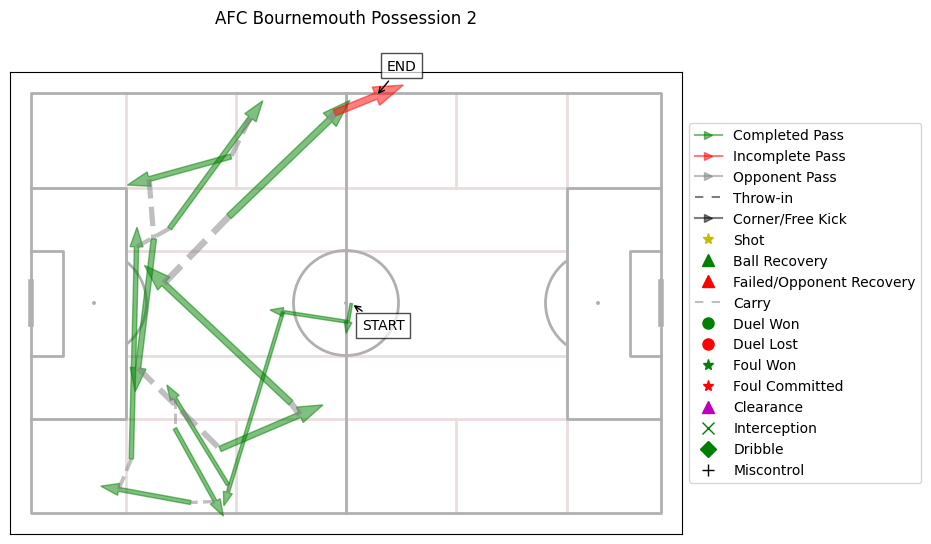

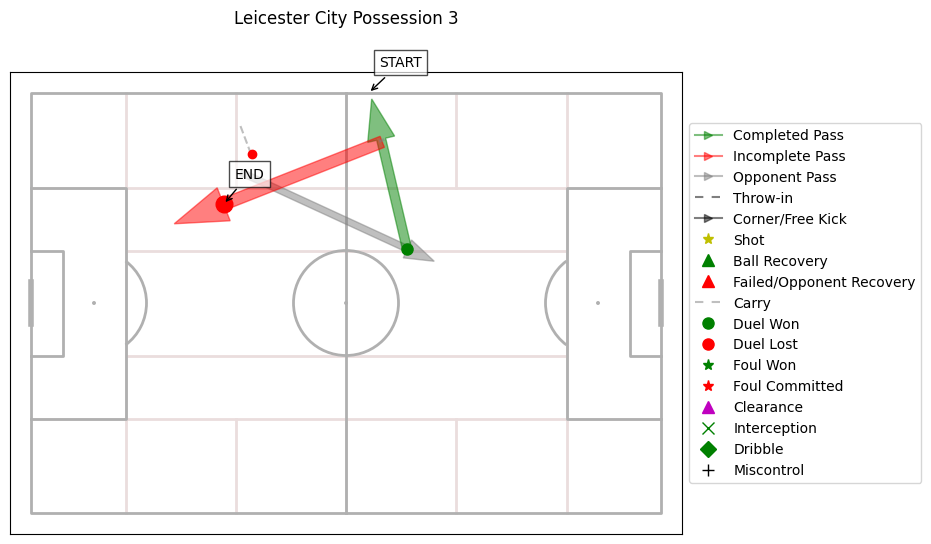

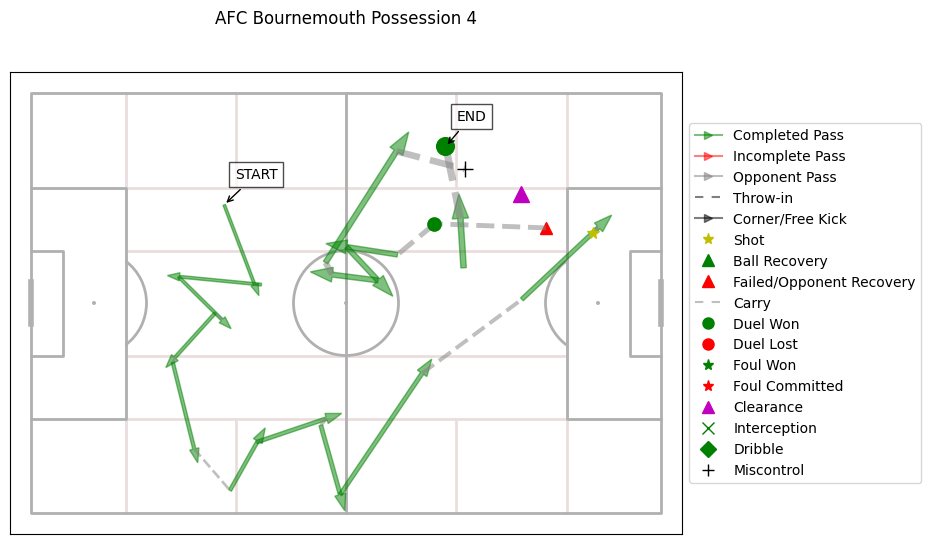

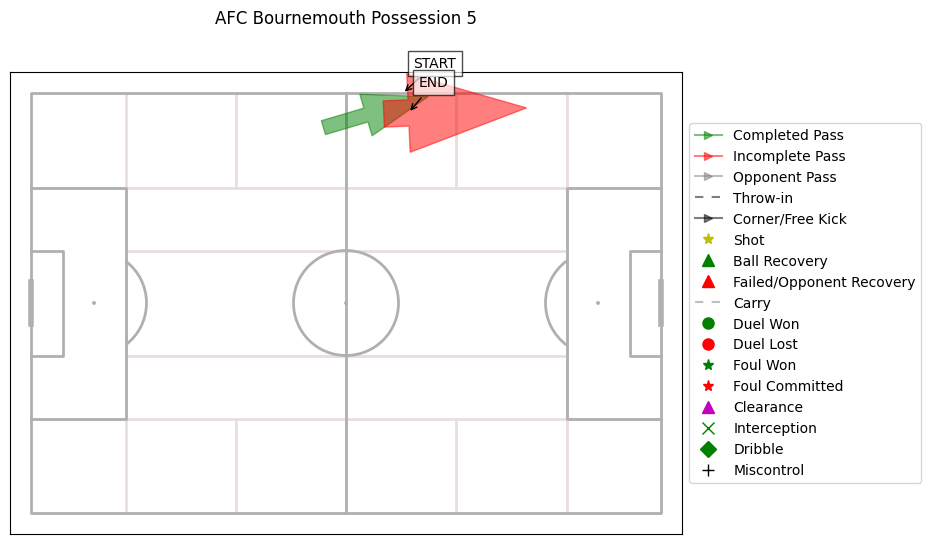

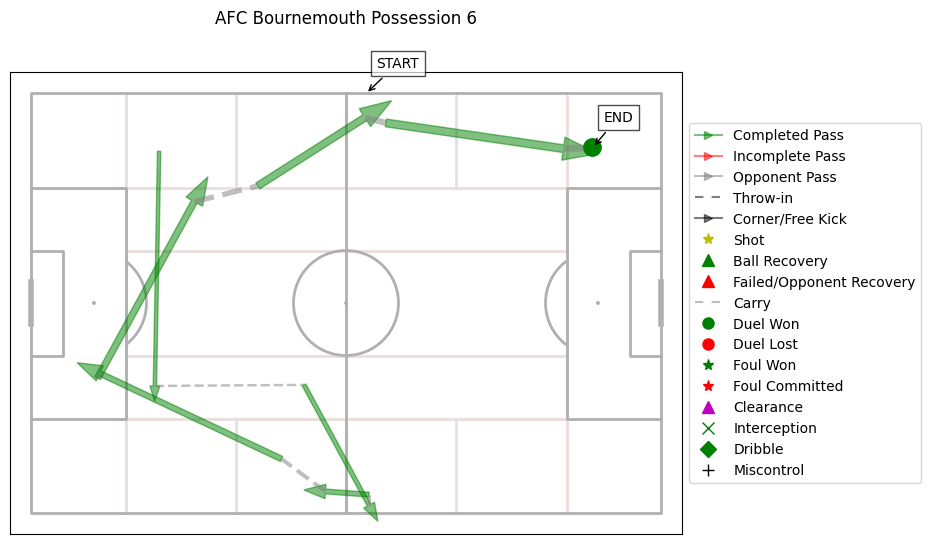

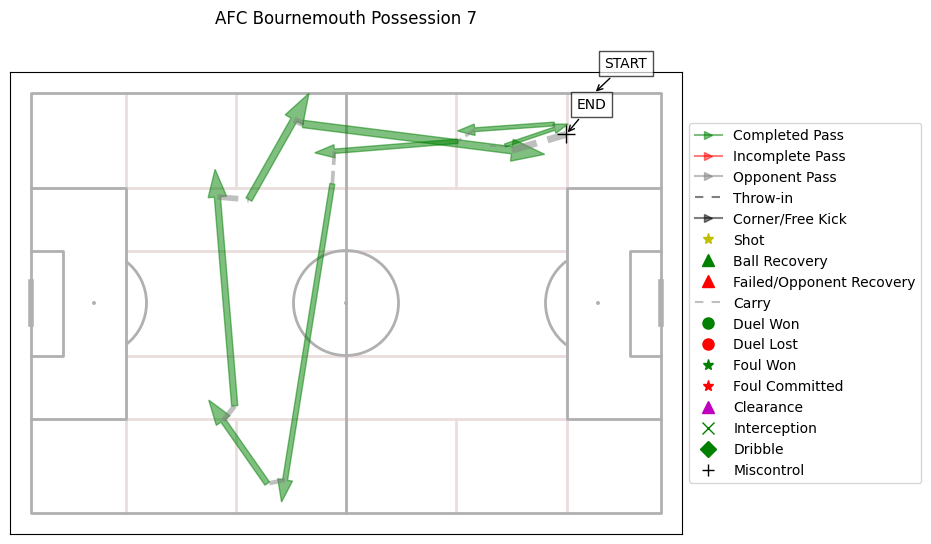

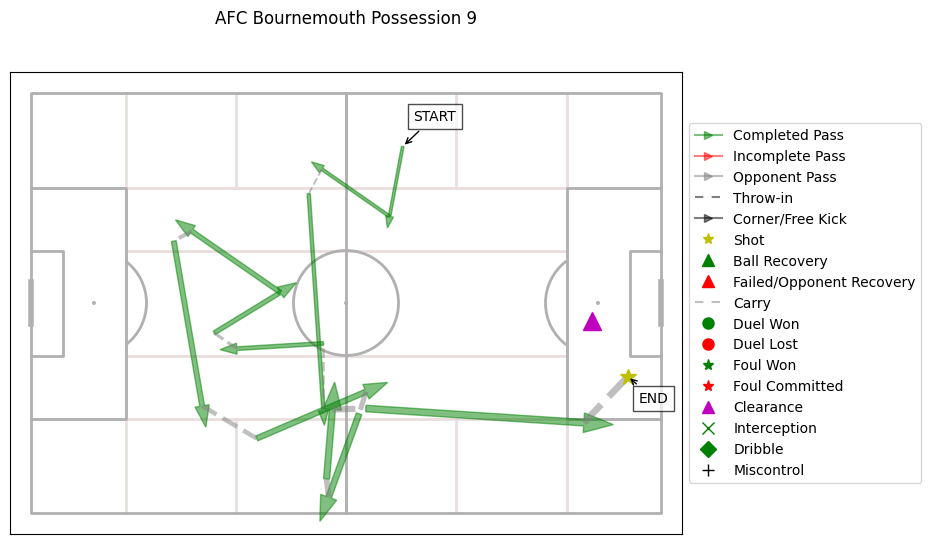

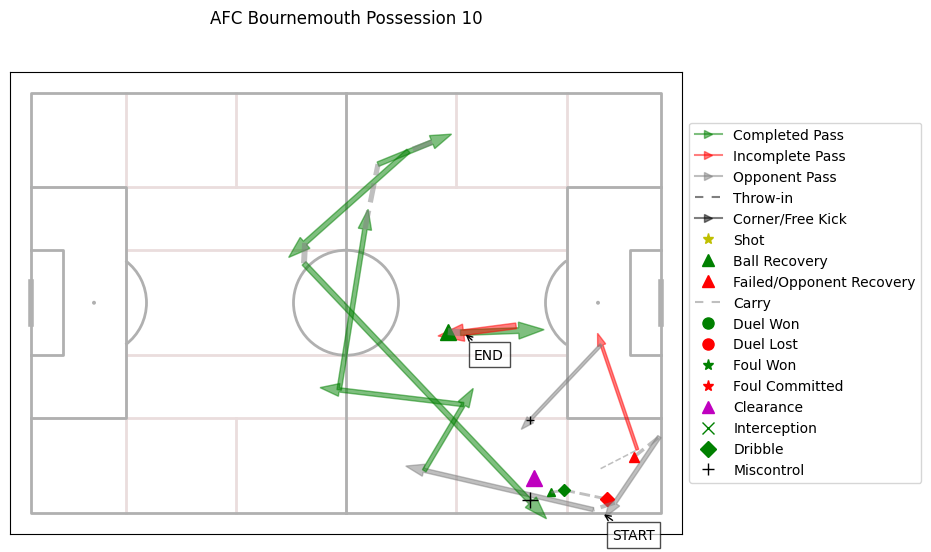

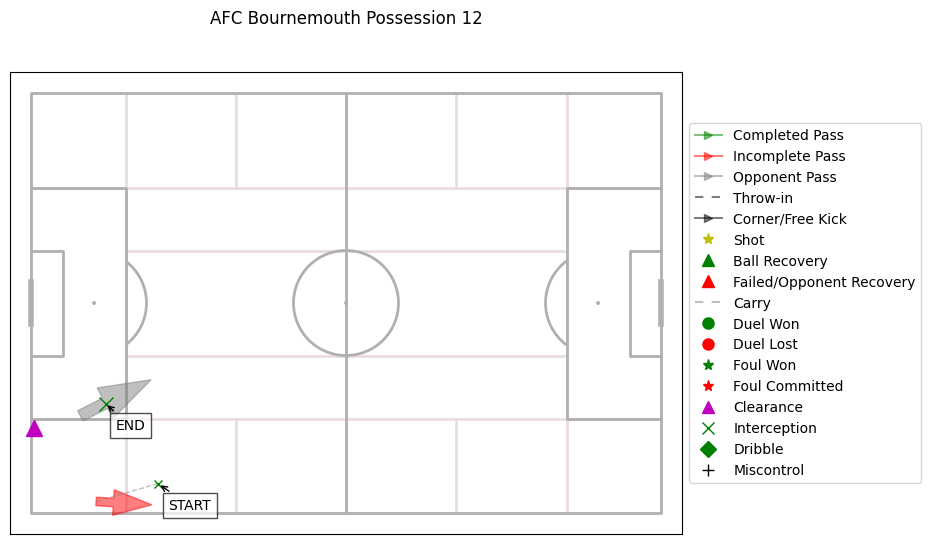

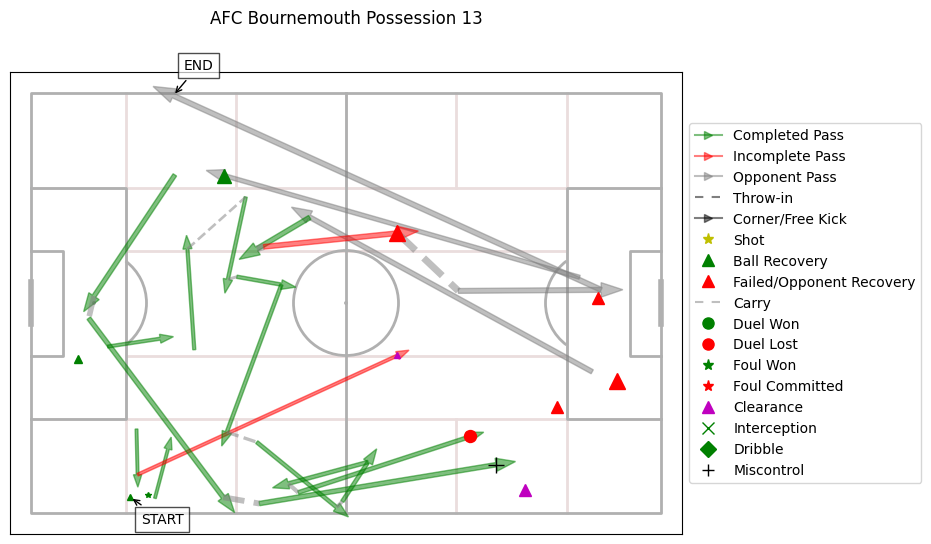

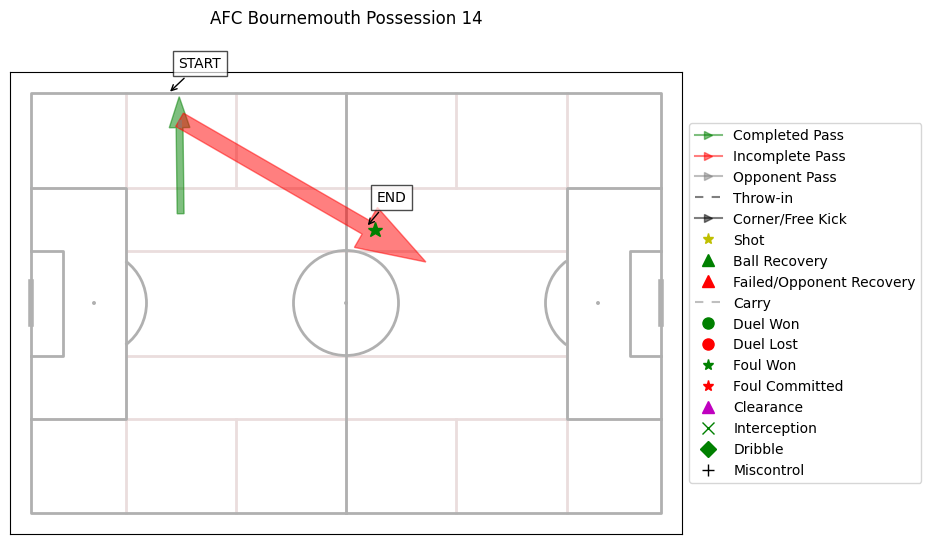

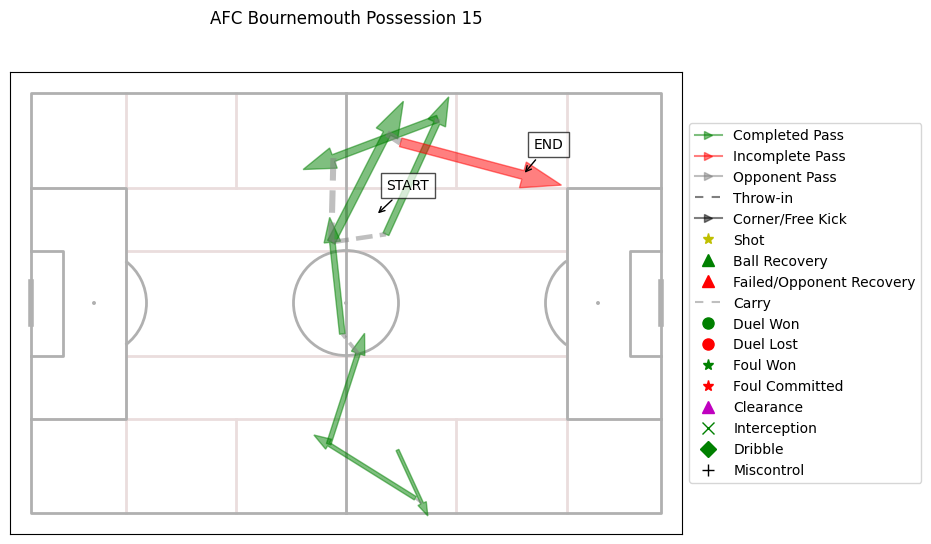

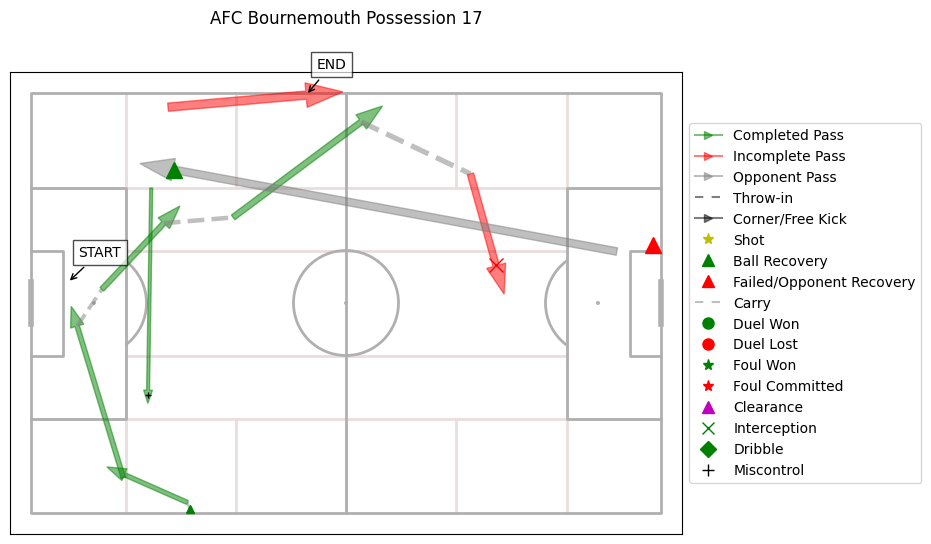

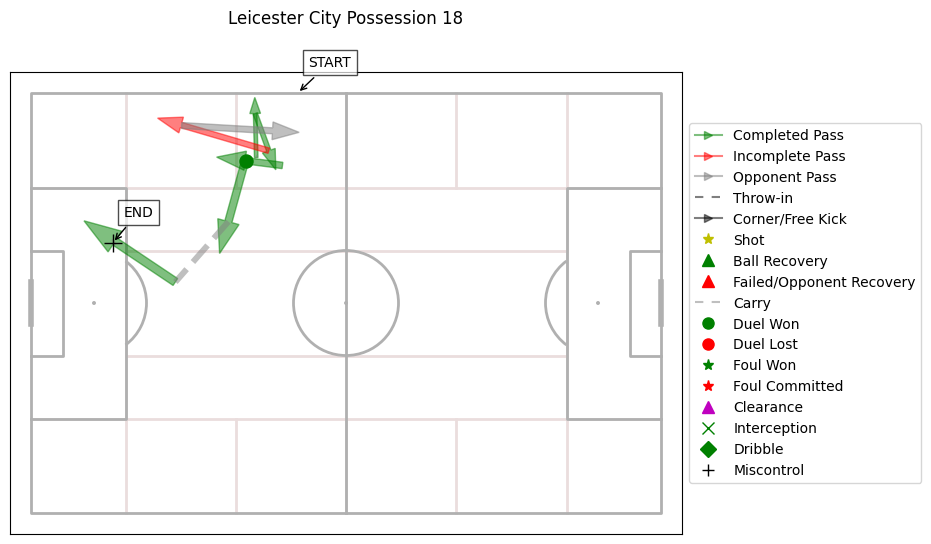

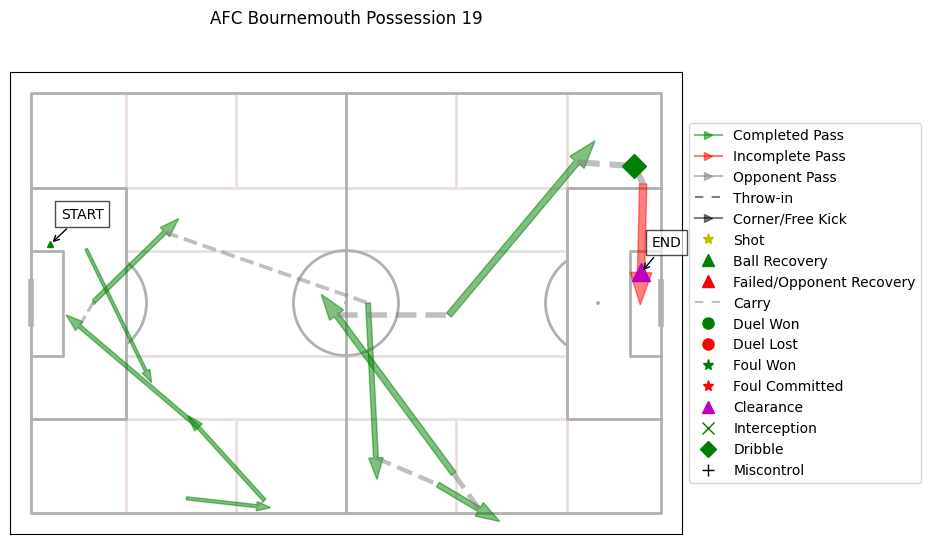

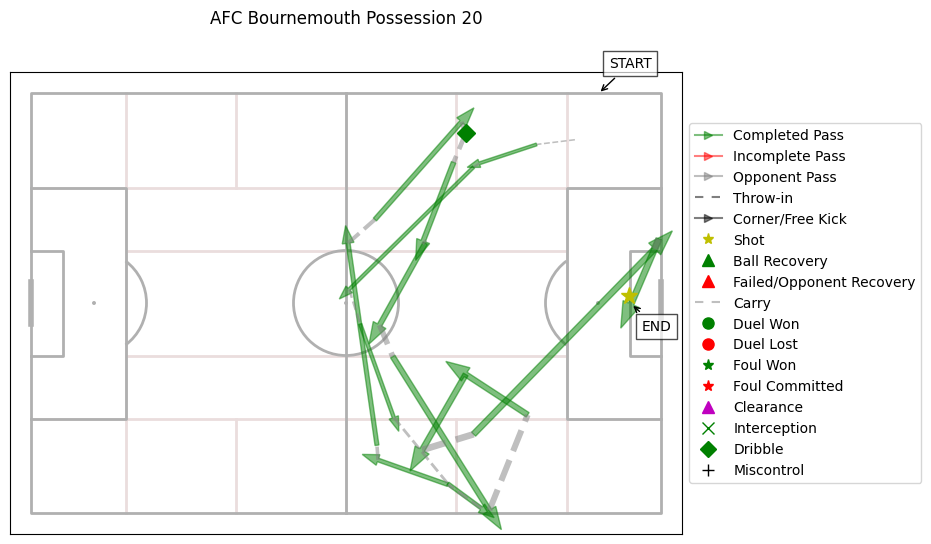

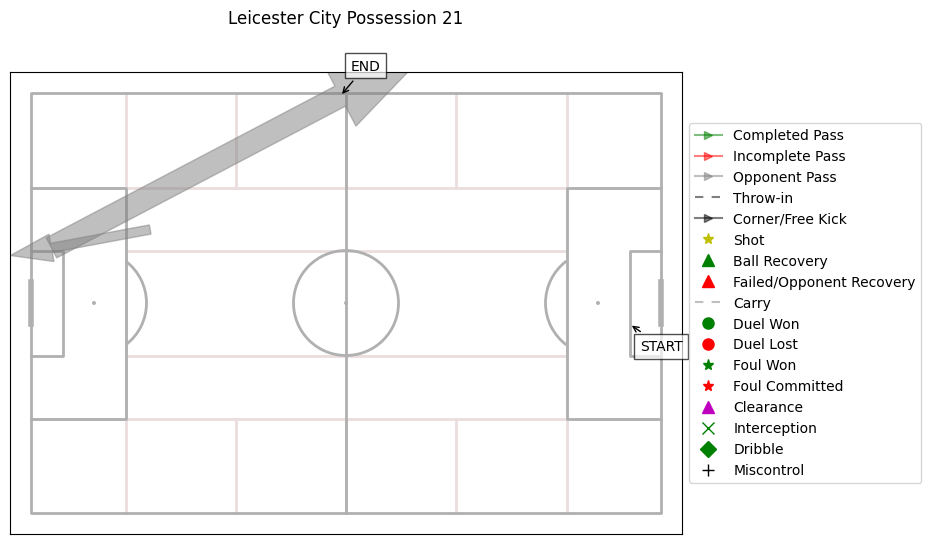

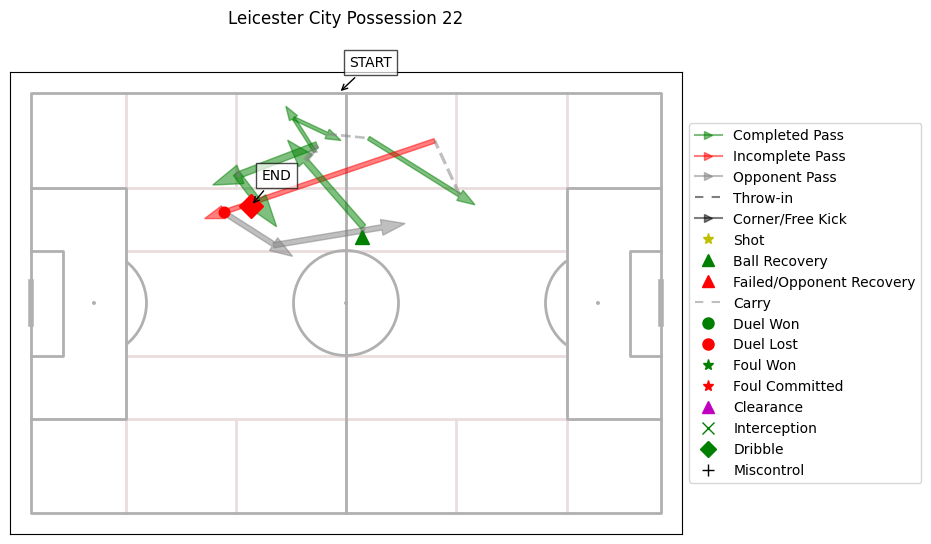

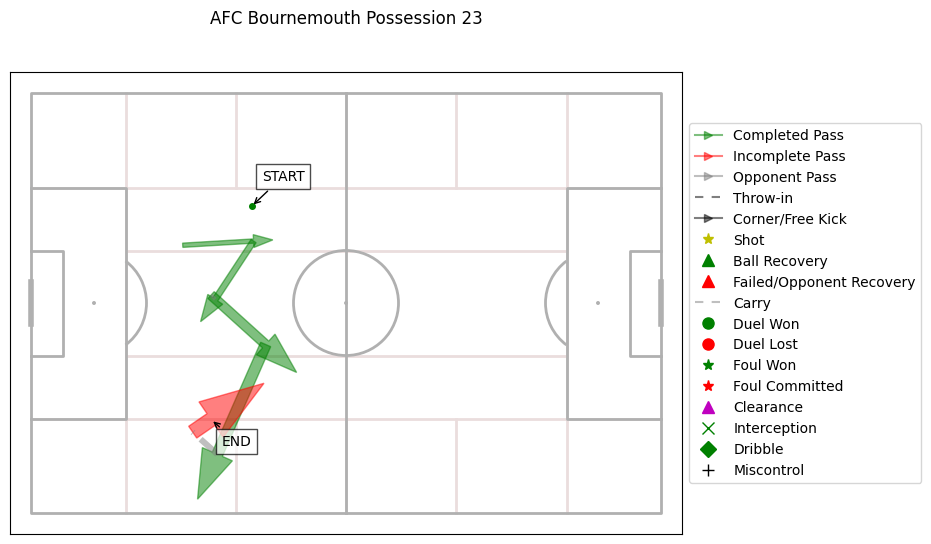

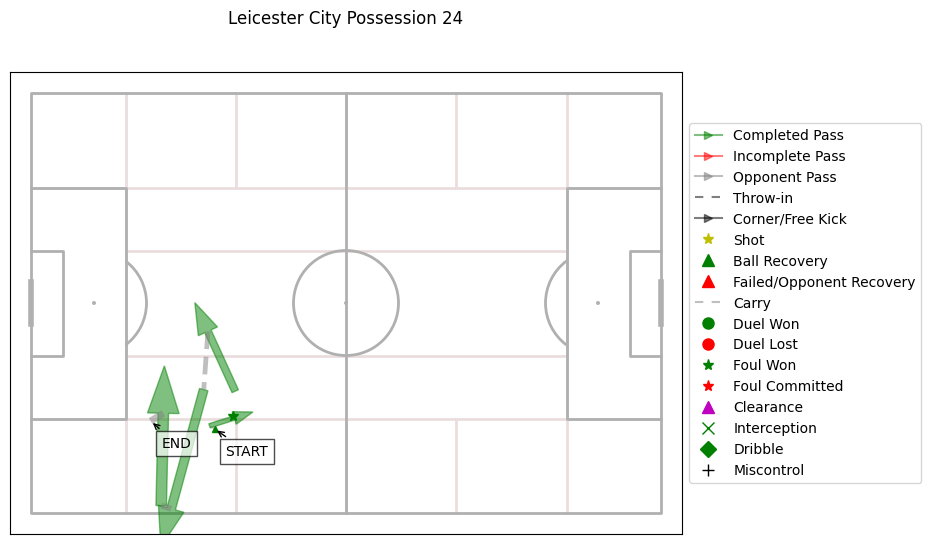

In [62]:
def plot_possession(possession):
    possession_events = ordered_events[ordered_events["possession"] == possession]
    team = possession_events["possession_team"].unique()[0]
    
    # Create pitch visualization
    pitch = Pitch(positional=True, axis=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    pitch.draw(ax=ax)
    
    # Sort events by timestamp and calculate width increment
    possession_events = possession_events.sort_values(by=["timestamp"], ascending=True)
    min_width = .5
    max_width = 5
    width_increment = (max_width - min_width) / len(possession_events)
    
    # Get first and last event locations
    first_event = possession_events.iloc[0]
    last_event = possession_events.iloc[-1]
    start_x, start_y = first_event["location"]
    end_x, end_y = last_event["location"]
    
    # Plot each event
    j=0
    for i, event in possession_events.iterrows():
        x, y = event["location"]
        event_team = event["team"]
        width = min_width + j * width_increment
        marker_size = 4 + j * 2

        if event["type"] == "Pass" and "pass_end_location" in event and isinstance(event["pass_end_location"], list):
            end_x, end_y = event["pass_end_location"]
            incomplete_outcomes = {"Incomplete", "Out", "Injury Clearance", "Pass Offside", "Unknown"}
            color = 'g' if event.get("pass_outcome") not in incomplete_outcomes else 'r'
            linestyle = (0, (4, 4, 4, 4)) if event["pass_type"] == "Throw-in" else '-'
            
            if event["pass_type"] in ["Corner", "Free Kick"]:
                color = 'k'
            if event_team != team:
                color = 'gray'
                
            plt.arrow(x, y, end_x-x, end_y-y, color=color, alpha=0.5, width=width, ls=linestyle)
            
        elif event["type"] == "Shot":
            plt.plot(x, y, 'y*', markersize=marker_size)
            
        elif event["type"] == "Ball Recovery":
            failed_recovery = (event["ball_recovery_recovery_failure"] == True and event_team == team)
            opponent_recovery = (event["ball_recovery_recovery_failure"] != True and event_team != team)
            color = 'r' if failed_recovery or opponent_recovery else 'g'
            plt.plot(x, y, f'{color}^', markersize=marker_size)
            
        elif event["type"] == "Carry" and "carry_end_location" in event and isinstance(event["carry_end_location"], list):
            end_x, end_y = event["carry_end_location"]
            plt.plot([x, end_x], [y, end_y], color='gray', alpha=0.5, linewidth=1+j, linestyle='--')
            
        elif event["type"] == "Duel":
            lost = "Lost" in event["duel_type"] or "Lost" in event["duel_outcome"]
            if event_team != team:
                lost = not lost  # Flip the outcome for opponent team
            color = 'r' if lost else 'g'
            plt.plot(x, y, f'{color}o', markersize=marker_size)
            
        elif event["type"] == "Foul Committed":
            color = 'g' if event_team != team else 'r'
            plt.plot(x, y, f'{color}*', markersize=marker_size)
            
        elif event["type"] == "Clearance":
            plt.plot(x, y, 'm^', markersize=marker_size)

        elif event["type"] == "Interception":
            interception_outcome = not ("Lost" in event.get('interception_outcome'))
            if interception_outcome & (event_team == team):
                color = 'g'
            elif interception_outcome & (event_team != team):
                color = 'r'
            elif not interception_outcome & (event_team != team):
                color = 'g'
            else:
                color = 'r'
            plt.plot(x, y, f'{color}x', markersize=marker_size)
        elif event["type"] == "Dribble":
            dribble_outcome = "Complete"==event.get('dribble_outcome')
            if dribble_outcome & (event_team == team):
                color = 'g'         
            else:
                color = 'r'
            plt.plot(x, y, f'{color}D', markersize=marker_size)
        elif event["type"] == "Miscontrol":
            plt.plot(x, y, 'k+', markersize=marker_size)
            
        j+=width_increment
    
    # Add start and end text annotations
    offset = 5
    start_offset = offset if start_y > 40 else -offset
    end_offset = offset if end_y > 40 else -offset
    plt.annotate('START', xy=(start_x, start_y), xytext=(start_x+2, start_y+start_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    plt.annotate('END', xy=(end_x, end_y), xytext=(end_x+2, end_y+end_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    
    # Add title after annotations to ensure it's on top
    plt.title(f"{team} Possession {possession}", pad=35)  # Added padding to avoid overlap
            
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='g', marker='>', linestyle='-', label='Completed Pass', alpha=0.5),
        plt.Line2D([0], [0], color='r', marker='>', linestyle='-', label='Incomplete Pass', alpha=0.5),
        plt.Line2D([0], [0], color='gray', marker='>', linestyle='-', label='Opponent Pass', alpha=0.5),
        plt.Line2D([0], [0], color='k', linestyle=(0, (4, 4, 4, 4)), label='Throw-in', alpha=0.5),
        plt.Line2D([0], [0], color='k', marker='>', linestyle='-', label='Corner/Free Kick', alpha=0.5),
        plt.Line2D([0], [0], color='y', marker='*', linestyle='none', label='Shot', markersize=8),
        plt.Line2D([0], [0], color='g', marker='^', linestyle='none', label='Ball Recovery', markersize=8),
        plt.Line2D([0], [0], color='r', marker='^', linestyle='none', label='Failed/Opponent Recovery', markersize=8),
        plt.Line2D([0], [0], color='gray',linestyle=(0, (4, 4, 4, 4)), label='Carry', alpha=0.5),
        plt.Line2D([0], [0], color='g', marker='o', linestyle='none', label='Duel Won', markersize=8),
        plt.Line2D([0], [0], color='r', marker='o', linestyle='none', label='Duel Lost', markersize=8),
        plt.Line2D([0], [0], color='g', marker='*', linestyle='none', label='Foul Won', markersize=8),
        plt.Line2D([0], [0], color='r', marker='*', linestyle='none', label='Foul Committed', markersize=8),
        plt.Line2D([0], [0], color='m', marker='^', linestyle='none', label='Clearance', markersize=8),
        plt.Line2D([0], [0], color='g', marker='x', linestyle='none', label='Interception', markersize=8),
        plt.Line2D([0], [0], color='g', marker='D', linestyle='none', label='Dribble', markersize=8),
        plt.Line2D([0], [0], color='k', marker='+', linestyle='none', label='Miscontrol', markersize=8),
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

for possession in ordered_events["possession"].unique()[:20]:
    plot_possession(possession)

In [63]:
# Get all shots and their xG values
shots = ordered_events[ordered_events.type == "Shot"]
#Deduplicate by possession (e.g., keeping the first shot)
shots_dedup = shots.drop_duplicates(subset="possession")[["shot_statsbomb_xg", "possession"]] # first shot in possession
shots_max = shots.groupby("possession")[["shot_statsbomb_xg"]].max().reset_index() # max xG in possession
shots_sum = shots.groupby("possession")[["shot_statsbomb_xg"]].sum().reset_index() # sum xG in possession

ordered_events = ordered_events.merge(shots_max.rename(columns={"shot_statsbomb_xg": "max_xg_in_possession"}), 
                                      on="possession", how="left")



In [64]:
# Filter events that are part of possessions with shots (non-null max_xg)
events_with_shots = ordered_events[ordered_events['max_xg_in_possession'].notna()]
print(f"Number of events in possessions with shots: {len(events_with_shots)}")
print("\nSample of events with shots:")
display(events_with_shots.head(5))


Number of events in possessions with shots: 313

Sample of events with shots:


,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,dribble_nutmeg,dribble_outcome,dribble_overrun,...,shot_technique,shot_type,team,team_id,timestamp,type,under_pressure,outcome,end_loc,max_xg_in_possession
29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,AFC Bournemouth,28,00:01:05.446,Pass,True,True,"[42.6, 36.5]",0.020838
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,AFC Bournemouth,28,00:01:08.273,Pass,NaN,True,"[28.3, 35.0]",0.020838
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,AFC Bournemouth,28,00:01:09.646,Pass,True,True,"[36.4, 43.2]",0.020838
32,NaN,"[35.1, 41.9]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,AFC Bournemouth,28,00:01:10.975,Carry,True,True,"[35.1, 41.9]",0.020838
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,AFC Bournemouth,28,00:01:12.957,Pass,True,True,"[27.4, 50.4]",0.020838


In [65]:
ordered_events[ordered_events["possession"]==2][["type","pass_outcome","pass_type","duel_outcome"]]

,type,pass_outcome,pass_type,duel_outcome
0,Pass,NaN,Kick Off,NaN
1,Carry,NaN,NaN,NaN
2,Pass,NaN,NaN,NaN
3,Pass,NaN,NaN,NaN
4,Carry,NaN,NaN,NaN
5,Pass,NaN,NaN,NaN
6,Carry,NaN,NaN,NaN
7,Pass,NaN,NaN,NaN
8,Carry,NaN,NaN,NaN
9,Pass,NaN,NaN,NaN


In [66]:
#how possessions start
ordered_events.groupby("possession").first()[["type","pass_outcome","duel_outcome","pass_type"]].head(50)




,type,pass_outcome,duel_outcome,pass_type
possession,,,,
2,Pass,Out,None,Kick Off
3,Duel,Incomplete,Success In Play,Recovery
4,Pass,None,Won,Recovery
5,Throw-in,Incomplete,None,Throw-in
6,Throw-in,None,Lost Out,Throw-in
7,Throw-in,None,None,Throw-in
8,Throw-in,Incomplete,None,Throw-in
9,Pass,None,None,Recovery
10,Throw-in,Incomplete,None,Throw-in
